<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Equação-de-propagação" data-toc-modified-id="Equação-de-propagação-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Equação de propagação</a></span><ul class="toc-item"><li><span><a href="#Solução-da-equação-de-propagação-(Split-Step-Fourier---SSF)" data-toc-modified-id="Solução-da-equação-de-propagação-(Split-Step-Fourier---SSF)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Solução da equação de propagação (Split-Step Fourier - SSF)</a></span><ul class="toc-item"><li><span><a href="#Exemplo" data-toc-modified-id="Exemplo-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Exemplo</a></span></li></ul></li><li><span><a href="#Método-symmetrized-split-step-Fourier" data-toc-modified-id="Método-symmetrized-split-step-Fourier-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Método symmetrized split-step Fourier</a></span><ul class="toc-item"><li><span><a href="#Exemplo---single-span" data-toc-modified-id="Exemplo---single-span-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Exemplo - single span</a></span></li><li><span><a href="#Exemplo---multiple-spans" data-toc-modified-id="Exemplo---multiple-spans-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Exemplo - multiple spans</a></span></li></ul></li></ul></li><li><span><a href="#Transmissão-10G-OOK---40-km" data-toc-modified-id="Transmissão-10G-OOK---40-km-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Transmissão 10G OOK - 40 km</a></span></li></ul></div>

In [19]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [20]:
import numpy as np
import scipy.special as sp
from  scipy.constants import c
import matplotlib.pyplot as plt
from utils.dsp import firFilter, pulseShape, eyediagram, lowPassFIR
from commpy.utilities  import signal_power, upsample
from utils.models import mzm

In [21]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Equação de propagação

A equação que descreve a propagação de um pulso óptico em uma fibra óptica com coeficiente de perdas igual a $\alpha$, coeficiente GVD $\beta_2$ e coeficiente não linear $\gamma$ é igual a
\begin{equation}
i\frac{\partial A}{\partial z} + i \frac{\alpha}{2}A - \frac{\beta_2}{2}\frac{\partial^2 A}{\partial t^2} + \gamma\left| A \right|^2 A = 0,
\end{equation}
em que $A(z,t)$ é a amplitude do sinal na posição $z$ e tempo $t$. Importante lembrar que o parâmetro de dispersão [ps/(km.nm)] é definido como
\begin{equation}
D = -\frac{2\pi c}{\lambda^2}\beta_2
\end{equation}
e o coeficiente não linear é
\begin{equation}
\gamma = \frac{n_2\omega_0}{c A_{eff}},
\end{equation}
sendo $A_{eff}$ a área efetiva do modo na fibra que varia entre 20-100 $\mu$m$^2$ na região 1550 nm. A área efetiva é definida como $A_{eff} = \pi w^2$, em que $w$ [m] é o *spot size* do modo. Ainda, $n_2$ [m$^2$/W] representa o coeficiente de índice não linear. 

## Solução da equação de propagação (Split-Step Fourier - SSF)

A equação de propagação pode ser expressa na forma de operadores:
\begin{equation}
\frac{\partial A}{\partial z} = \left[ \hat{D} + \hat{N} \right]A
\end{equation}
em que
\begin{align}
\hat{D} &= -i\frac{\beta_2}{2} \frac{\partial^2}{\partial t^2}-\frac{\alpha}{2} \\
\hat{N} &= i\gamma \left| A \right|^2
\end{align}
Denominamos $\hat{D}$ operador linear e $\hat{N}$ operador não linear. A solução aproximada é
\begin{equation}
A\left(z+h,t\right) \approx A\left(z,t\right) e^{h\hat{D}} e^{h\hat{N}}
\end{equation}
A avaliação do operador linear é realizado da forma
\begin{equation}
A\left(z,t\right) e^{h\hat{D}} = \mathcal{F}^{-1} \left\{ e^{h\hat{D}\left(j \omega \right)} \mathcal{F}\left[A(z,t)\right] \right\}
\end{equation}
em que $\mathcal{F}\left[ A(z,t) \right]$ é a transformada de Fourier da envoltória $ A(z,t)$.

O fluxograma que descreve o método SSF é:

<img src="./figuras/SSF_non_symmetric.png" width="250">

In [30]:
def SSF_non_symmetric(E, hz, Lspan, alpha, gamma, D, Fc, Fs):
    λ  = c/Fc
    α  = 1e-3*alpha/(10*np.log10(np.exp(1)))
    β2 = -(D*λ**2)/(2*np.pi*c)
            
    Nfft = len(E)
    ω = 2*np.pi*Fs*np.fft.fftfreq(Nfft)
    
    z = 0
    while z <= Lspan:
        # Operador linear
        E = np.fft.fft(E)
        E = E*np.exp(-α*hz+1j*(β2/2)*(ω**2)*hz)

        # Operador não linear
        E = np.fft.ifft(E)            
        E = E*np.exp(1j*gamma*(np.abs(E)**2)*hz)
        
        z = z + hz
    return E,z

### Exemplo

In [202]:
Lspan = 10e3  # m
hz    = 0.1e2  # m
alpha = 0.2    # dB/km
gamma = 1.3e-3 # W-1/m
D  = 0#16e-6     # s/(m*m)
Fc = 193.1e12  # Hz
Fs = 64e9      # Hz
P0 = 1e-3      # W

In [203]:
def GaussPulse(a0, t0, t):      # Expressão do pulso Gaussiano
  return a0*np.exp(-0.5*(t/t0)**2)
def FGaussPulse(a0, t0, freq):  # Transformada de Fourier do pulso Gaussiano (analítica)
  return a0*t0*np.sqrt(2*np.pi)*np.exp(-0.5*(2*np.pi*freq*t0)**2)

In [204]:
t0 = 0.1
fs = 80                         # Taxa de amostragem
t  = np.arange(-0.5,0.5,1/fs)   # Duração da janela do pulso
E  = GaussPulse(np.sqrt(P0), t0, t)

In [205]:
E_out, z  = SSF_non_symmetric(E, hz, Lspan, alpha, gamma, D, Fc, Fs)

In [206]:
alpha_lin = 1e-3*alpha/(10*np.log10(np.exp(1)))
E_rx = E_out*np.exp(alpha_lin * z)

In [207]:
delta_w = -np.diff(np.angle(E_rx))/(t[1]-t[0])

z = 10.010000 km


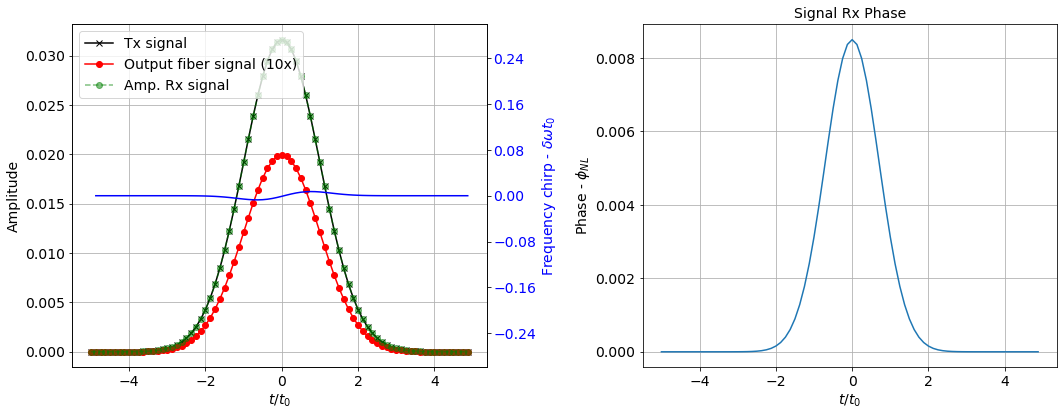

In [208]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].plot(t/t0, np.abs(E),     'kx-',  label = 'Tx signal')
axs[0].plot(t/t0, np.abs(E_out), 'ro-',  label = 'Output fiber signal (10x)')
axs[0].plot(t/t0, np.abs(E_rx),  'go--', label = 'Amp. Rx signal', alpha = 0.5)
axs[0].set_xlabel(r'$t/t_0$')
axs[0].set_ylabel('Amplitude')
#axs[0].set_ylim([0,0.2])
axs[0].legend(loc = 'upper left')
axs[0].grid(True)

axs1 = axs[0].twinx()
axs1.plot(t[1:]/t0, t0*delta_w, 'blue')
axs1.set_ylabel('Frequency chirp - $\delta \omega t_0$', color = 'blue')
axs1.tick_params(axis='y', labelcolor='blue')
axs1.set_ylim([-.3,.3])
axs1.yaxis.set_major_locator(plt.MaxNLocator(9))

axs[1].plot(t/t0, np.angle(E_rx))
axs[1].set_xlabel(r'$t/t_0$')
axs[1].set_ylabel('Phase - $\phi_{NL}$')
axs[1].set_title('Signal Rx Phase')
axs[1].grid(True)
print('z = %f km' %(1e-3*z))

fig.tight_layout()

In [209]:
NFFT = len(E_rx)
f    = fs/NFFT * np.arange(-NFFT/2,NFFT/2)
Xa   = FGaussPulse(np.sqrt(P0), t0, f)             # Trasnformada de Fourier do pulso transmitido
E_rx_FFT = np.fft.fftshift(np.fft.fft(E_rx, NFFT)) # Transformada de Fourier do pulso recebido

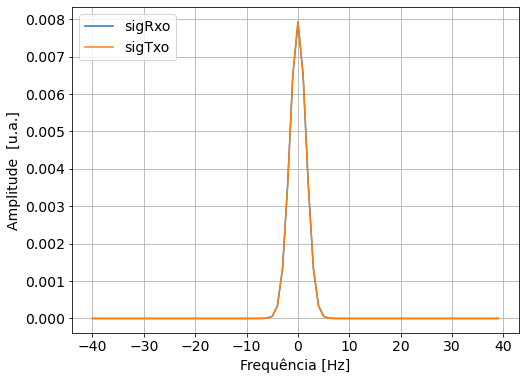

In [210]:
fig =plt.figure(figsize=(8,6))
plt.plot(f, abs(E_rx_FFT)/NFFT, label = 'sigRxo')
plt.plot(f, Xa, label = 'sigTxo')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Amplitude  [u.a.]')
plt.grid(True)
plt.legend(loc = 'upper left')

## Método symmetrized split-step Fourier

O erro do método de solução apresentado na subseção anterior é proporcional à $h^2$. A acurácia do método SSF pode ser melhorado adotando um procedimento diferente para a propagação do pulso óptico. Assim, o procedimento pode ser substituído por:
\begin{equation}
A\left( z+h, t \right) \approx \text{exp}{\left(\frac{h}{2}\hat{D}\right)} \, \text{exp}{\left( h \hat{N}\right)} \, \text{exp}{\left(\frac{h}{2}\hat{D}\right)} \, A\left(z, t\right)
\end{equation}
Neste caso, o erro é proporcional à $h^3$. O fluxograma que descreve o método S-SSF é

<img src="./figuras/SSF_symmetric.png" width="250">

In [229]:
def SSF_symmetric(E, hz, Lspan, alpha, gamma, D, Fc, Fs):
    λ  = c/Fc
    α  = 1e-3*alpha/(10*np.log10(np.exp(1)))
    β2 = -(D*λ**2)/(2*np.pi*c)
            
    Nfft = len(E)

    ω = 2*np.pi*Fs*np.fft.fftfreq(Nfft)
    z = 0
    
    E = np.fft.fft(E)
    
    while z <= Lspan:
        # Primeiro passo - operador linear
        E = E*np.exp(-α*(hz/2)+1j*(β2/2)*(ω**2)*(hz/2))

        # Operador não linear
        E = np.fft.ifft(E)            
        E = E*np.exp(1j*gamma*(np.abs(E)**2)*hz)
        
        # Segundo passo - operador linear
        E = np.fft.fft(E)
        E = E*np.exp(-α*(hz/2)+1j*(β2/2)*(ω**2)*(hz/2))
        
        z = z + hz
        
    E = np.fft.ifft(E)
    return E,z

### Exemplo - single span

In [160]:
E_out, z  = SSF_symetric(E, hz, Lspan, alpha, gamma, D, Fc, Fs)
alpha_lin = 1e-3*alpha/(10*np.log10(np.exp(1)))
E_rx = E_out*np.exp(alpha_lin * z)

In [161]:
delta_w = -np.diff(np.angle(E_rx))/(t[1]-t[0])

z = 100.100000 km


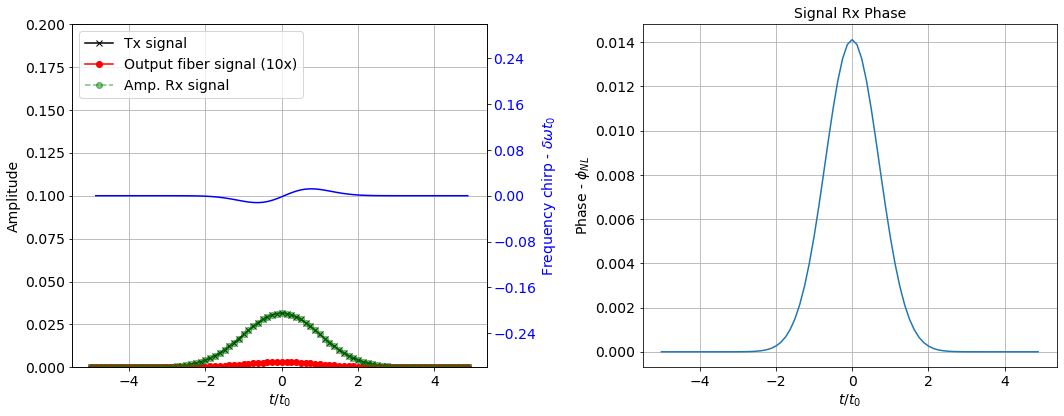

In [162]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].plot(t/t0,    np.abs(E),     'kx-',  label = 'Tx signal')
axs[0].plot(t/t0, 10*np.abs(E_out), 'ro-',  label = 'Output fiber signal (10x)')
axs[0].plot(t/t0,    np.abs(E_rx),  'go--', label = 'Amp. Rx signal', alpha = 0.5)
axs[0].set_xlabel(r'$t/t_0$')
axs[0].set_ylabel('Amplitude')
axs[0].set_ylim([0,0.2])
axs[0].legend(loc = 'upper left')
axs[0].grid(True)

axs1 = axs[0].twinx()
axs1.plot(t[1:]/t0, t0*delta_w, 'blue')
axs1.set_ylabel('Frequency chirp - $\delta \omega t_0$', color = 'blue')
axs1.tick_params(axis='y', labelcolor='blue')
axs1.set_ylim([-.30,.30])
axs1.yaxis.set_major_locator(plt.MaxNLocator(9))

axs[1].plot(t/t0, np.angle(E_rx))
axs[1].set_xlabel(r'$t/t_0$')
axs[1].set_ylabel('Phase - $\phi_{NL}$')
axs[1].set_title('Signal Rx Phase')
axs[1].grid(True)
print('z = %f km' %(1e-3*z))

fig.tight_layout()

In [163]:
NFFT = len(E_rx)
f    = fs/NFFT * np.arange(-NFFT/2,NFFT/2)
Xa   = FGaussPulse(np.sqrt(P0), t0, f)             # Trasnformada de Fourier do pulso transmitido
E_rx_FFT = np.fft.fftshift(np.fft.fft(E_rx, NFFT)) # Transformada de Fourier do pulso recebido

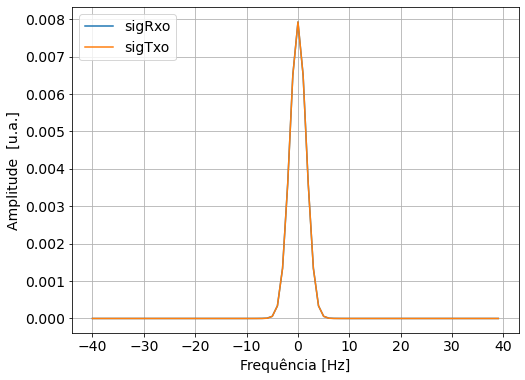

In [164]:
fig =plt.figure(figsize=(8,6))
plt.plot(f, abs(E_rx_FFT)/NFFT, label = 'sigRxo')
plt.plot(f, Xa, label = 'sigTxo')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Amplitude  [u.a.]')
plt.grid(True)
plt.legend(loc = 'upper left')

### Exemplo - multiple spans

In [165]:
Nspan   = 10 #1000 km total
E_amp_i = E
for i in range(Nspan):
    E_out_i, z = SSF_symetric(E_amp_i, hz, Lspan, alpha, gamma, D, Fc, Fs)    
    E_amp_i    = E_out_i*np.exp(alpha_lin * z)

In [166]:
delta_w = -np.diff(np.angle(E_amp_i))/(t[1]-t[0])

z = 100.100000 km


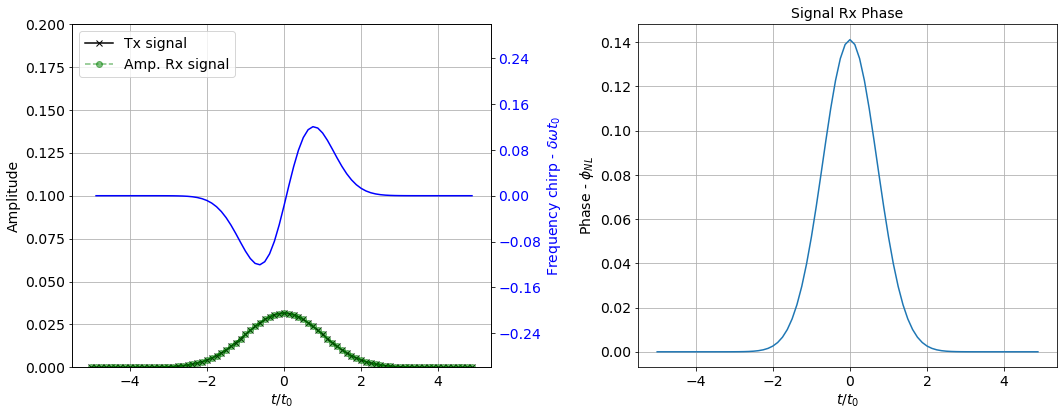

In [167]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].plot(t/t0,    np.abs(E),     'kx-',  label = 'Tx signal')
axs[0].plot(t/t0,    np.abs(E_amp_i),  'go--', label = 'Amp. Rx signal', alpha = 0.5)
axs[0].set_xlabel(r'$t/t_0$')
axs[0].set_ylabel('Amplitude')
axs[0].set_ylim([0,0.2])
axs[0].legend(loc = 'upper left')
axs[0].grid(True)

axs1 = axs[0].twinx()
axs1.plot(t[1:]/t0, t0*delta_w, 'blue')
axs1.set_ylabel('Frequency chirp - $\delta \omega t_0$', color = 'blue')
axs1.tick_params(axis='y', labelcolor='blue')
axs1.set_ylim([-.30,.30])
axs1.yaxis.set_major_locator(plt.MaxNLocator(9))

axs[1].plot(t/t0, np.angle(E_amp_i))
axs[1].set_xlabel(r'$t/t_0$')
axs[1].set_ylabel('Phase - $\phi_{NL}$')
axs[1].set_title('Signal Rx Phase')
axs[1].grid(True)
print('z = %f km' %(1e-3*z))

fig.tight_layout()

In [168]:
NFFT = len(E_amp_i)
f    = fs/NFFT * np.arange(-NFFT/2,NFFT/2)
Xa   = FGaussPulse(np.sqrt(P0), t0, f)                # Trasnformada de Fourier do pulso transmitido
E_rx_FFT = np.fft.fftshift(np.fft.fft(E_amp_i, NFFT)) # Transformada de Fourier do pulso recebido

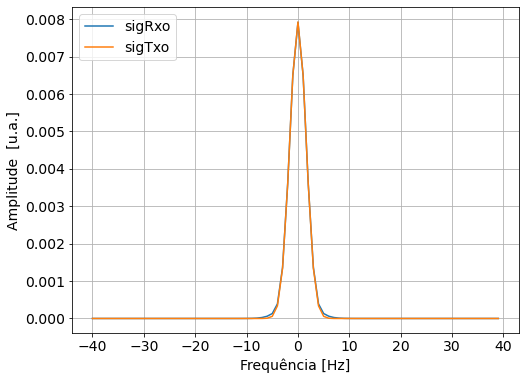

In [169]:
fig =plt.figure(figsize=(8,6))
plt.plot(f, abs(E_rx_FFT)/NFFT, label = 'sigRxo')
plt.plot(f, Xa, label = 'sigTxo')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Amplitude  [u.a.]')
plt.grid(True)
plt.legend(loc = 'upper left')

# Transmissão 10G OOK - 40 km

In [219]:
# parâmetros da simulação
SpS = 32
Rs  = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

In [256]:
# Parâmetros do sinal
lmbd   = 1550e-9       # comprimento de onda
Pi_dBm = 10            # potência de sinal óptico na entrada do modulador em dBm

In [257]:
# Parâmetros do MZM
Vπ = 2
Vb = -Vπ/2
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

In [258]:
# Parâmetros da fibra
alpha = 0.16   # dB/Km
D     = 18e-6  # Parâmetro de dispersão s/(m*m) - SMF28 (ps/(nm*km))
gamma = 4*1.3e-3 # W-1/m
Lspan = 40e3   # Comprimento do enlace m
hz    = 0.1e3  # m

In [259]:
# Parâmetros do receptor
Rd  = 0.85      # responsividade em A/W

In [260]:
# gera sequência de bits pseudo-aleatórios
bits   = np.random.randint(2, size=10000)    
n      = np.arange(0, bits.size)

# mapeia bits para pulsos elétricos
symbTx = 2*bits-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# plota sinal 
t = np.arange(0, symbTx.size)*(Ta/1e-9)

#idX = np.arange(0,513)
idX = np.arange(0,1023)

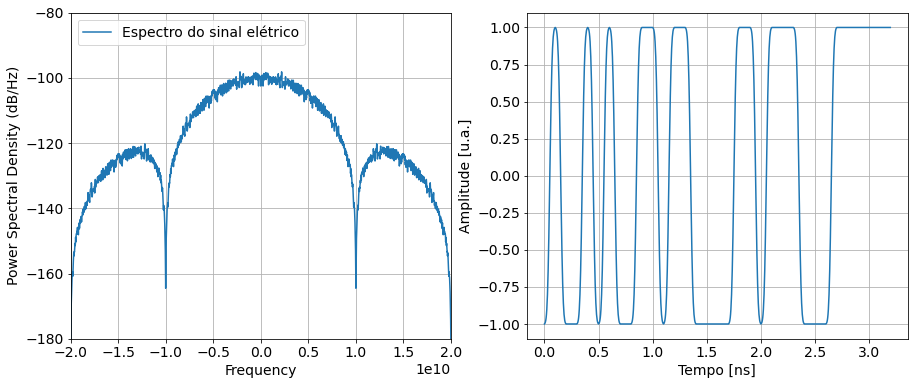

In [261]:
# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# plota psd
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].set_xlim(-2*Rs,2*Rs);
axs[0].set_ylim(-180,-80);
axs[0].psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal elétrico')
axs[0].legend(loc='upper left')

axs[1].plot(t[idX], sigTx[idX].real)
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)

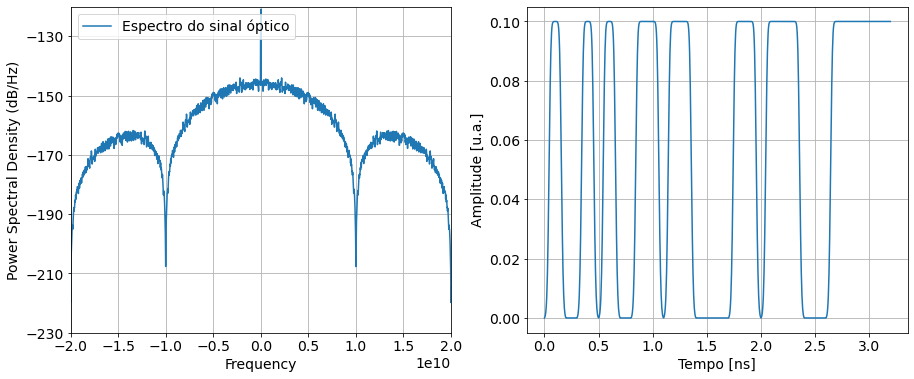

In [262]:
# modulação óptica
Ai     = np.sqrt(Pi)
sigTxo = mzm(Ai, Vπ, sigTx, Vb)

# plota psd
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].set_xlim(-2*Rs,2*Rs);
axs[0].set_ylim(-230,-120);
axs[0].psd(np.abs(sigTxo)**2,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
axs[0].legend(loc='upper left')

axs[1].plot(t[idX], np.abs(sigTxo[idX]))
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)

In [263]:
# transmissão óptica
NFFT = len(sigTxo)
sigTxoFFT = np.fft.fftshift(np.fft.fft(sigTxo))/NFFT
sigTxoPx  = np.abs(sigTxoFFT)**2
freq = np.fft.fftshift(np.fft.fftfreq(len(sigTxoFFT), Ta))

# Fibra óptica
sigRxo, z = SSF_symmetric(sigTxo, hz, Lspan, alpha, gamma, D, Fc, Fa) # Propagation

alpha_lin = 1e-3*alpha/(10*np.log10(np.exp(1)))
sigRxo    = sigRxo*np.exp(alpha_lin * z)                             # Amplification

sigRxoFFT = np.fft.fftshift(np.fft.fft(sigRxo))/NFFT
sigRxoPx  = np.abs(sigRxoFFT)**2

Potência do sinal Tx (em dBm) = 6.95 dBm
Potência do sinal Rx (em dBm) = 6.95 dBm


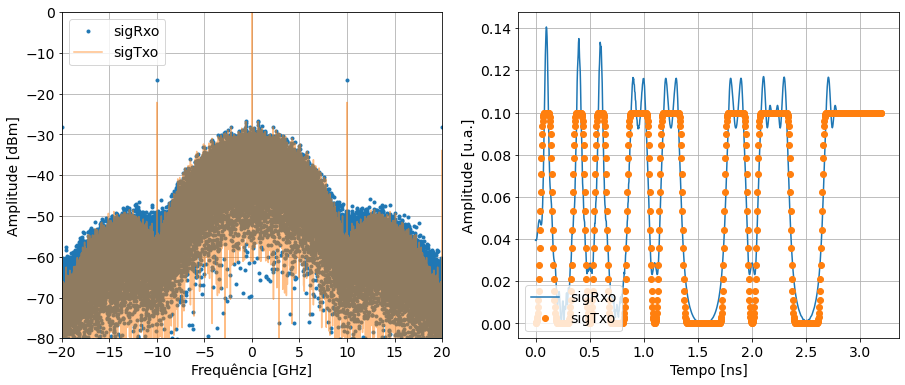

In [264]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))
axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigRxoPx), '.', label = 'sigRxo')
axs[0].plot(1e-9*freq, 10*np.log10(1e3*sigTxoPx), alpha = 0.5, label = 'sigTxo')
axs[0].set_ylabel('Amplitude [dBm]')
axs[0].set_xlabel('Frequência [GHz]')
axs[0].set_xlim(-2e-9*Rs,2e-9*Rs)
axs[0].set_ylim(-80,0)
axs[0].grid(True)
axs[0].legend(loc = 'upper left')

axs[1].plot(t[0:1023], np.abs(sigRxo[0:1023]), label = 'sigRxo')
axs[1].plot(t[0:1023], np.abs(sigTxo[0:1023]), 'o', label = 'sigTxo')
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)
axs[1].legend(loc = 'lower left')

print('Potência do sinal Tx (em dBm) = %.2f dBm' %(10*np.log10(np.sum(sigTxoPx)/1e-3)))
print('Potência do sinal Rx (em dBm) = %.2f dBm' %(10*np.log10(np.sum(sigRxoPx)/1e-3)))

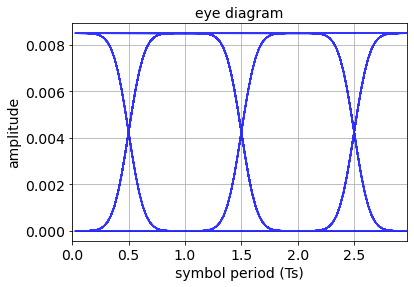

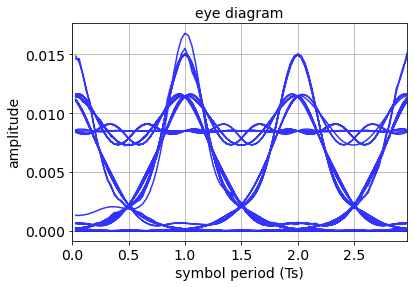

In [265]:
# Recepção do sinal óptico
Nsamples = 2**12

# fotocorrente livre de ruído
Ip   = Rd*np.abs(sigTxo)**2
I_Rx = Rd*np.abs(sigRxo)**2

# diagrama de olho
eyediagram(Ip,  Nsamples, SpS)
eyediagram(I_Rx, Nsamples, SpS)